White

In [36]:
import scipy.constants as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [37]:
def ode_solve_rk(f, y0, r):
    """
    Solves dy/dt = f(y,t) using a Runge-Kutta algorithm
    Input:  f - a function that receives the current state, y, and the current position and returns the derivative value of the statement, dy/dr
            y0 - the initial state of the system, given in a column matrix (Mx1)
            r - vector of position steps with length N where the values of y will be returned
    Output: y - (MxN) matrix that contains the values of y at every position/time step. Columns correspond to the position/time and rows to the element of y
    """
    y0 = np.array(y0)
    y = np.zeros((len(y0), len(r))) # Initiates output y matrix
    for i, ri in enumerate(r): # Cycling through r, applying the Runge-Kutta algorithm at each step
        dr = ri if i==0 else (r[i]-r[i-1]) # Finds gap between r values (non-constant so required to be within loop)
        f0 = f(y0, ri)
        f1 = f((y0 + f0*(dr/2)), ri)
        f2 = f((y0 + f1*(dr/2)), ri)
        f3 = f((y0 + f2*dr), ri)
        y4 = y0 + ((f0 + 2*f1 + 2*f2 + f3) * (dr/6))
        y[:,i] = y4
        y0 = y4
    return y

In [38]:
def get_density(rho0, r, rel=False):
    """
    Obtains the density as a function of the radial distance using the ODE solver and the non-relativistic equation
    Input:  rho0 - the central density at r = 0
            r - the grid points of radial distance where the density is calculated in the form of a vector with N elements
            rel - boolean distinguishing relativistic and non-relativistic cases
    Output: rho - an N-element vector that contains the density at the radial grid points given in r
            mass - an N-element vector of teh cumulative mass of the white dwarf star from r=0 to the radial grid point given in r
    """
    dr = r[0]
    m0 = (4/3)*sc.pi*(dr**3)*rho0 # Initial value of m
    y0 = [rho0, m0]
    if rel == False:
        y = ode_solve_rk(DyDr, y0, r) # Use non-relativistic equation of state
        #y = solve_ivp(DyDr, y0, r, method="RK45")
    else:
        y = ode_solve_rk(DyDr_rel, y0, r) # Use relativistic equation of state
        #y = solve_ivp(DyDr_rel, y0, r, method="RK45")
    rho = y[0,:]
    mass = y[1,:]
    return(rho, mass)

In [39]:
def DyDr(y, r):
    """
    Calculates the mass and density derivatives at values y, r using the non-relativistic equations of state
    Input:  y - 2x1 dimensional array containing values of the density and mass
            r - the distance from the centre of the star 
    Output: dydr - 2x1 dimensional array containing values of the density and mass derivatives
    """
    dydr = []
    dPdp = (((sc.h**2)*(2**(1/3)))/(48*sc.electron_mass*(sc.proton_mass**(5/3))))*(((3*y[0])/(sc.pi))**(2/3)) # Calculating dP/dp
    dpdr = (-1 * (1/dPdp) * ((sc.G*y[0]*y[1])/(r**2))) # Calculating dp/dr
    dydr.append(dpdr)
    dmdr = (4 * sc.pi * (r**2) * y[0]) # Calculating dm/dr
    dydr.append(dmdr)
    dydr = np.array(dydr)
    return dydr

In [40]:
def DyDr_rel(y, r):
    """
    Calculates the mass and density derivatives at values y, r using the relativistic equations of state
    Input:  y - 2x1 dimensional array containing values of the density and mass
            r - the distance from the centre of the star 
    Output: dydr - 2x1 dimensional array containing values of the density and mass derivatives
    """
    dydr = []
    A = (8 * sc.pi * (sc.electron_mass**4) * (sc.c**5))/(3 * (sc.h**3)) # Calculating variables A, Pf, a, dP/da, da/dPf, dPf/dp to be used to calculate dP/dp
    Pf = ((3 * (sc.h**3) * y[0])/(16 * sc.pi * sc.proton_mass))**(1/3)
    a = np.arcsinh(Pf/(sc.electron_mass*sc.c))
    dPda = A * (np.sinh(a)**4)
    dadPf = ((Pf**2)+((sc.electron_mass*sc.c)**2))**(-1/2)
    dPfdp = (((3 * (sc.h**3))/(16 * sc.pi * sc.proton_mass))**(1/3)) * (1/3) * (y[0]**(-2/3))
    dPdp = dPda * dadPf * dPfdp # Calculating dP/dp
    dpdr = (-1/dPdp) * ((sc.G * y[0] * y[1])/(r**2)) # Calculating dp/dr
    dydr.append(dpdr)
    dmdr = 4 * sc.pi * (r**2) * y[0] # Calculating dm/dr
    dydr.append(dmdr)
    dydr = np.array(dydr)
    return dydr

In [41]:
# Calculating mass and density values for a central density of 1e13 (non-relativistic)

rho0 = 1e13
r = np.logspace(-1, 3.5 , 1000, base=100) # Using a logarithmic separation to get an even spread of values
rho, mass = get_density(rho0, r)

C:\Users\KiriCord\AppData\Local\Temp\ipykernel_13184\1394553715.py:9: RuntimeWarning: invalid value encountered in double_scalars
  dPdp = (((sc.h**2)*(2**(1/3)))/(48*sc.electron_mass*(sc.proton_mass**(5/3))))*(((3*y[0])/(sc.pi))**(2/3)) # Calculating dP/dp


Text(0, 0.5, 'Mass [kg]')

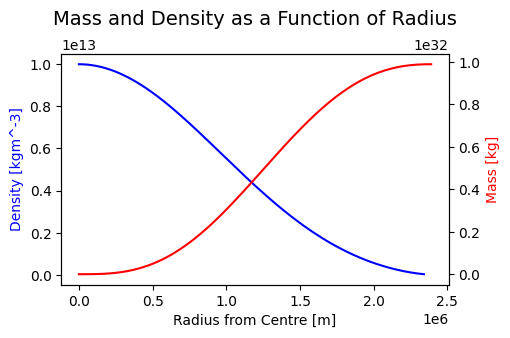

In [42]:
# Plotting mass and density as a function of radius for a central density of 1e13 (non-relativistic)

plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title('Mass and Density as a Function of Radius', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.plot(r, rho, color='blue')
ax.set_xlabel('Radius from Centre [m]', fontsize=10)
ax.set_ylabel("Density [kgm^-3]", color='blue', fontsize=10)
ax2 = ax.twinx()
ax2.plot(r, mass, color='red')
ax2.set_ylabel('Mass [kg]', color='red', fontsize=10)
#plt.savefig('Mass and Density vs Radius.png', dpi = 300, bbox_inches='tight')

In [43]:
# Calculating the outer radius and total mass of the star with central density 1e13 (non-relativistic)

Outer_radius = r[np.argmax(rho<(0.005*rho0))-1] # Finds the first value of the radius when the density is less than 0.5% of the central density
Total_mass = mass[np.argmax(rho<(0.005*rho0))-1] # Finds the first value of the mass when the density is less than 0.5% of the central density
print(Outer_radius, Total_mass)

2292769.312865649 9.869386374606364e+31


In [44]:
# Calculating a range of outer radii and total mass's of stars over a range of central densities (non-relativistic)

rho0 = np.logspace(6, 14, 1000) # Central density ranging from 1e6 to 1e14
r = np.logspace(-1, 4 , 1000, base=100)
rad = []
total_mass = []
for r0 in rho0:
    rho, mass = get_density(r0, r, rel=False) # Calculates values of mass and density for each central density
    rad.append(r[np.argmax(rho<(0.005*r0))-1])
    total_mass.append(mass[np.argmax(rho<(0.005*r0))-1])

C:\Users\KiriCord\AppData\Local\Temp\ipykernel_13184\1394553715.py:9: RuntimeWarning: invalid value encountered in double_scalars
  dPdp = (((sc.h**2)*(2**(1/3)))/(48*sc.electron_mass*(sc.proton_mass**(5/3))))*(((3*y[0])/(sc.pi))**(2/3)) # Calculating dP/dp


Text(0, 0.5, 'Total Mass [kg]')

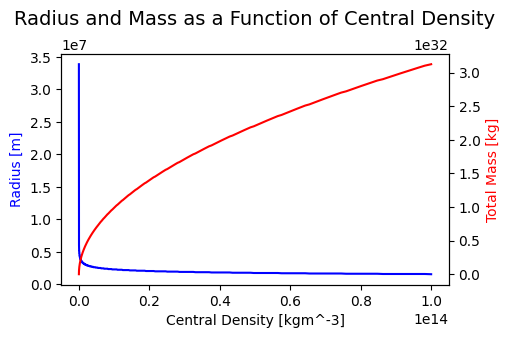

In [45]:
# Plotting the outer radii and total mass as a function of central density (non-relativistic)

plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title('Radius and Mass as a Function of Central Density', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.plot(rho0, rad, color='blue')
ax.set_xlabel('Central Density [kgm^-3]', fontsize=10)
ax.set_ylabel("Radius [m]", color='blue', fontsize=10)
ax2 = ax.twinx()
ax2.plot(rho0, total_mass, color='red')
ax2.set_ylabel('Total Mass [kg]', color='red', fontsize=10)
#plt.savefig('Radius and Mass vs Central Density.png', dpi = 300, bbox_inches='tight')

In [46]:
# Calculating a range of outer radii and total mass's of stars over a range of central densities (relativistic)

rho0 = np.logspace(6, 14, 1000) # Central density values ranging from 1e6 to 1e14
r = np.logspace(-1, 4, 1000, base=100)
rad_rel = []
total_mass_rel = []
for r0 in rho0:
    rho, mass = get_density(r0, r, rel=True) # Calculates values of mass and density for each central density using relativistic equations
    rad_rel.append(r[np.argmax(rho<(0.005*r0))-1])
    total_mass_rel.append(mass[np.argmax(rho<(0.005*r0))-1])

C:\Users\KiriCord\AppData\Local\Temp\ipykernel_13184\443820535.py:10: RuntimeWarning: invalid value encountered in double_scalars
  Pf = ((3 * (sc.h**3) * y[0])/(16 * sc.pi * sc.proton_mass))**(1/3)
C:\Users\KiriCord\AppData\Local\Temp\ipykernel_13184\443820535.py:14: RuntimeWarning: invalid value encountered in double_scalars
  dPfdp = (((3 * (sc.h**3))/(16 * sc.pi * sc.proton_mass))**(1/3)) * (1/3) * (y[0]**(-2/3))


Text(0, 0.5, 'Total Mass [kg]')

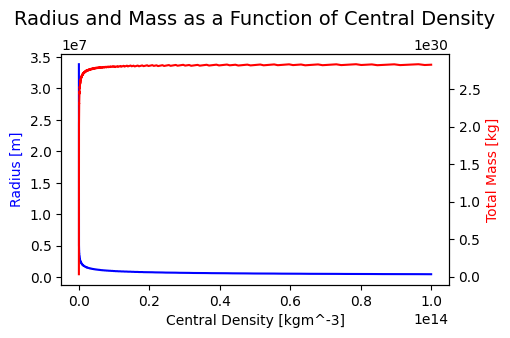

In [47]:
# Plotting the outer radii and total mass as a function of central density

plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize=(5,3))
ax.set_title('Radius and Mass as a Function of Central Density', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.plot(rho0, rad_rel, color='blue')
ax.set_xlabel('Central Density [kgm^-3]', fontsize=10)
ax.set_ylabel("Radius [m]", color='blue', fontsize=10)
ax2 = ax.twinx()
ax2.plot(rho0, total_mass_rel, color='red')
ax2.set_ylabel('Total Mass [kg]', color='red', fontsize=10)
#plt.savefig('Relativistic Radius and Mass vs Central Density.png', dpi = 300, bbox_inches='tight')

In [48]:
# Converts total mass and radius to suitable plotting arrays

tmr = np.array([x/(1.989*(10**30)) for x in total_mass_rel])
tmr_s = tmr[tmr < 2]
rr = np.array([x for x in rad_rel])
rr_s = rr[tmr < 2]
tm = np.array([x/(1.989*(10**30)) for x in total_mass])
tm_s = tm[tm < 2]
r = np.array([x for x in rad])
r_s = r[tm < 2]

[Text(1.4202864824675772, 1, 'CM')]

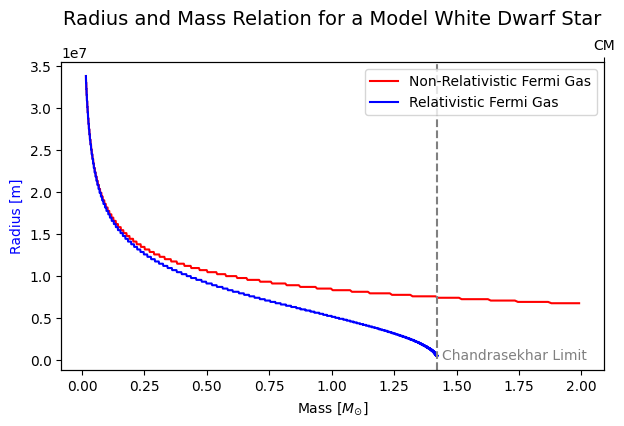

In [49]:
# Plots total radius as a function of total mass / solar mass

plt.rc('xtick',labelsize = 10)
plt.rc('ytick',labelsize = 10)
fig, ax = plt.subplots(figsize = (7,4))
ax.set_title('Radius and Mass Relation for a Model White Dwarf Star', pad=10, fontsize=14)
ax.ticklabel_format(style='sci', scilimits=(0,0))
ax.plot(tm_s, r_s, color='red', label = 'Non-Relativistic Fermi Gas')
ax.plot(tmr_s, rr_s, color='blue', label = 'Relativistic Fermi Gas')
ax.set_xlabel('Mass [$M_{\odot}$]', fontsize=10)
ax.set_ylabel("Radius [m]", color='blue', fontsize=10)
ax.legend(loc = 'upper right')
ax.axvline(tmr[-1], linestyle = '--', color = 'grey')
plt.text(tmr[-1]+0.02,0,'Chandrasekhar Limit', color = 'grey', fontsize = 10)
ax2 = ax.twiny()
ax2.set_xticks([tmr[-1]])
ax2.set_xticklabels(["CM"])
#plt.savefig('Radius Mass Relation.png', dpi = 300, bbox_inches='tight')

In [50]:
print(tmr[-1]) # Returns the calculated value of Chandrasekhar mass

1.4202864824675772
